# **Price Prediction of Bitcoin Based on Historical Data**

*- Krisbiantoro Prabowo*
<hr>

## **1. Description**
### 1.1. Objective
Milestones 2 ini bertujuan untuk:

- Mengenal  dan menggali informasi mengenai pergerakan harga cryptocurrency khususnya pada bitcoin(BTC) terhadap usd(USDT)
- Mampu membuat model Neural Network(NN) yang dapat memprediksi harga BTC/USDT
- Model NN yang telah dibuat mampu memprediksi harga BTC/USDT dengan data yang baru saja masuk(inference)

### 1.2. About Dataset
Diberikan sebuah dataset berupa historical data dari pergerakan BTC terhadap USD. Kolom yang diberikan seperti pada umumnya memiliki informasi mengenai OHLC (Open, High, Low, Close) dan informasi lain yang berkaitan seperti tanggal dan jam terjadinya transaksi. Data Transaksi yang dicatat merupakan data tiap jam dan mulai direkam mulai dari 17 Agustus 2018

### 1.3. Problem Statement
Kita adalah seorang **day trader** dimana kita sering melakukan `Open Posisi/Trade` di hari yang sama. Oleh karena itu kita terbiasa menggunakan chart berbagai time frame salah satunya ialah 1 jam(perubahan harga tiap jamnya). Karena sering menggunakan time frame tersebut, kita ingin setidaknya mengetahui harga penutupan pada time frame 1 jam kedepannya. Dengan hal ini kita memiliki pandangan setidaknya dari prediksi yang dilakukan apakah harga bergerak naik, stagnan, atau justru turun. Diharapkan dengan mengetahui pergerakan ini, dapat membantu kita apakah kondisi harga pada saat itu nantinya ideal untuk dilakukan `Open Trade` dengan definisi rules atau aturan trading yang sudah kita tetapkan.

### 1.4. Useful Links
- Dataset: [here](https://www.kaggle.com/datasets/oscardavidperilla/historical-bitcoin-prices-btc)
- Colab: [here]()
- Heroku(deployment): [here](https://krisbiantoro-p2-m2.herokuapp.com/)
<hr>

## **2. Import Libraries**

In [81]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import pickle
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten, GRU
from keras import optimizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mplfinance as fplt

pd.options.mode.chained_assignment = None

In [82]:
colors = sns.color_palette("Set2")
colors2 = sns.color_palette("Paired")
sns.set_style("whitegrid")
plt.style.use('seaborn-pastel')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## **3. Data Loading**

In [83]:
df = pd.read_csv('BTCUSDT_1h.csv')

In [84]:
df.head()

,open,high,low,close,volume,close_time,quote,takers_buy_base,takers_buy_quote
0,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-16 23:59:59.999000-05:00,202366.138393,35.160503,150952.477943
1,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 00:59:59.999000-05:00,100304.823567,21.448071,92608.279728
2,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 01:59:59.999000-05:00,31282.312670,4.802861,20795.317224
3,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 02:59:59.999000-05:00,19241.058300,2.602292,11291.347015
4,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 03:59:59.999000-05:00,4239.503586,0.814655,3552.746817


## **4. Exploratory Data Analysis**

### 4.1. Brief Information

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38461 entries, 0 to 38460
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              38461 non-null  float64
 1   high              38461 non-null  float64
 2   low               38461 non-null  float64
 3   close             38461 non-null  float64
 4   volume            38461 non-null  float64
 5   close_time        38461 non-null  object 
 6   quote             38461 non-null  float64
 7   takers_buy_base   38461 non-null  float64
 8   takers_buy_quote  38461 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.6+ MB


- Tidak ditemukannya missing value pada keseluruhan kolom, khususnya kolom yang akan kita gunakan yaitu `close`. Ini dapat memudahkan kita untuk mengolah data dan mempersiapkan data sebelum masuk ke Neural Network, karena dapat langsung menggunakan data secara utuh

In [86]:
num_columns = df.select_dtypes(include=np.number).columns.tolist()
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['open', 'high', 'low', 'close', 'volume', 'quote', 'takers_buy_base', 'takers_buy_quote']
Categorical Columns:  ['close_time']


- Karena data berisi informasi mengenai rekam transaksi BTC/USDT, wajar jika mayoritas kolom bertipe Numerik

### 4.2. Statistical Descriptive

In [87]:
df.describe()

,open,high,low,close,volume,quote,takers_buy_base,takers_buy_quote
count,38461.000000,38461.000000,38461.000000,38461.000000,38461.000000,3.846100e+04,38461.000000,3.846100e+04
mean,17589.002805,17696.560219,17473.314191,17589.962025,2101.814189,4.369855e+07,1046.701701,2.159233e+07
std,17359.685254,17463.372583,17249.006318,17359.989729,2175.337360,7.080532e+07,1066.267302,3.481741e+07
min,2870.900000,2950.000000,2817.000000,2919.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,6726.000000,6752.760000,6695.490000,6726.110000,919.149470,7.125238e+06,470.170524,3.665090e+06
50%,9298.330000,9339.370000,9259.980000,9298.750000,1536.182670,1.545427e+07,773.216614,7.739254e+06
75%,19024.330000,19125.760000,18900.000000,19026.490000,2571.497519,5.187811e+07,1279.230445,2.529690e+07
max,68635.120000,69000.000000,68451.190000,68633.690000,47255.762685,1.514465e+09,20628.794047,6.849674e+08


- Keseluruhan kolom khususnya pada kolom close tampaknya memiliki `outlier` dan memiliki pendistribusian data bersifat `skewed` jika dilihat dari gap atau selisih yang dihasilkan dari posisi Quartile 3 ke Quartile 4(Max)
- Dengan mengetahui bahwa harga cryptocurrency termasuk BTC sangatlah volatile (kenaikan ataupun turunnya harga memiliki rentang yang tinggi ), khususnya jika terdapat news yang memberikan dampak signifikan entah itu berita yang baik ataupun yang buruk pada interval waktu saat itu. Maka besar kemungkinan kolom akan memiliki outlier dan memiliki nilai varians/std yang juga tinggi. Namun outlier tersebut akan kita biarkan dan tidak ditangani sama sekali
- Hal ini dikarenakan kita membutuhkan informasi rentang tersebut dan oleh karena itu, untuk setidaknya memudahkan komputasi pada deep learning. Kita akan menormalisasi data harga pada kolom close dengan teknik `MinMaxScaler` dengan mengubah nilainya menjadi rentang dari 0 hingga 1

In [88]:
skewness = pd.DataFrame({'columns':df.describe().columns, 'skew' : df.skew(axis=0)})
skewness.reset_index(drop=True, inplace=True)
skewness['status'] = np.where(skewness['skew'].abs()>0.5, 'Skewed', 'Normal')
skewness

,columns,skew,status
0,open,1.390926,Skewed
1,high,1.387937,Skewed
2,low,1.394293,Skewed
3,close,1.390768,Skewed
4,volume,4.417486,Skewed
5,quote,4.546872,Skewed
6,takers_buy_base,4.292715,Skewed
7,takers_buy_quote,4.413420,Skewed


- Ternyata benar jika keseluruhan kolom memiliki status `skewed` khususnya pada kolom close

### 4.3. Columns Analysis

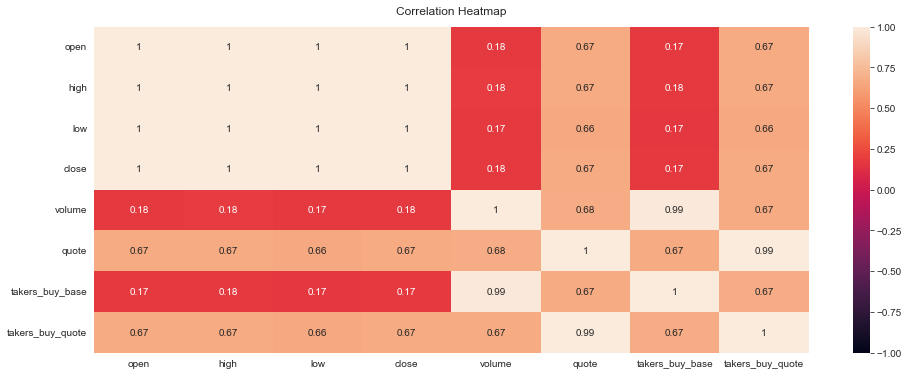

In [89]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

- Kolom OHLC, memiliki relasi yang sama sama kuat (bernilai 1). Hal ini wajar karena memang pada kolom-kolom ini mencatat rekam informasi harga tiap jamnya dan saling berhubungan dengan data-data sebelumnya

In [90]:
df_cor=df.corr()
for i in df_cor:
    j=0
    df_cor[i] = np.where(df_cor[i].abs()>0.1, df_cor[i], 'low')

In [91]:
for i in df_cor:
    print(f'Column: {i}')
    low_corr = df_cor[i][(df_cor[i] == "low")].value_counts().tolist()
    if low_corr:
        print('low:',low_corr)
    else:
        print('low:',0)
    print("="*20)

Column: open
low: 0
Column: high
low: 0
Column: low
low: 0
Column: close
low: 0
Column: volume
low: 0
Column: quote
low: 0
Column: takers_buy_base
low: 0
Column: takers_buy_quote
low: 0


- Tidak ditemukannya korelasi yang bernilai rendah (dibawah 0.1) antar tia-tiap kolom

### 4.4. Gather Some Information

### 4.4.1. Historical Bitcoin Prices

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38461 entries, 0 to 38460
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              38461 non-null  float64
 1   high              38461 non-null  float64
 2   low               38461 non-null  float64
 3   close             38461 non-null  float64
 4   volume            38461 non-null  float64
 5   close_time        38461 non-null  object 
 6   quote             38461 non-null  float64
 7   takers_buy_base   38461 non-null  float64
 8   takers_buy_quote  38461 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.6+ MB


In [93]:
# Removing the localization in 'close_time'
df['close_time'] = pd.to_datetime(df['close_time'], errors='coerce')
df['close_time'] = df['close_time'].dt.tz_localize(None)
# df['close_time'] = df['close_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_plot = df.copy()
df_plot = df_plot.set_index('close_time')

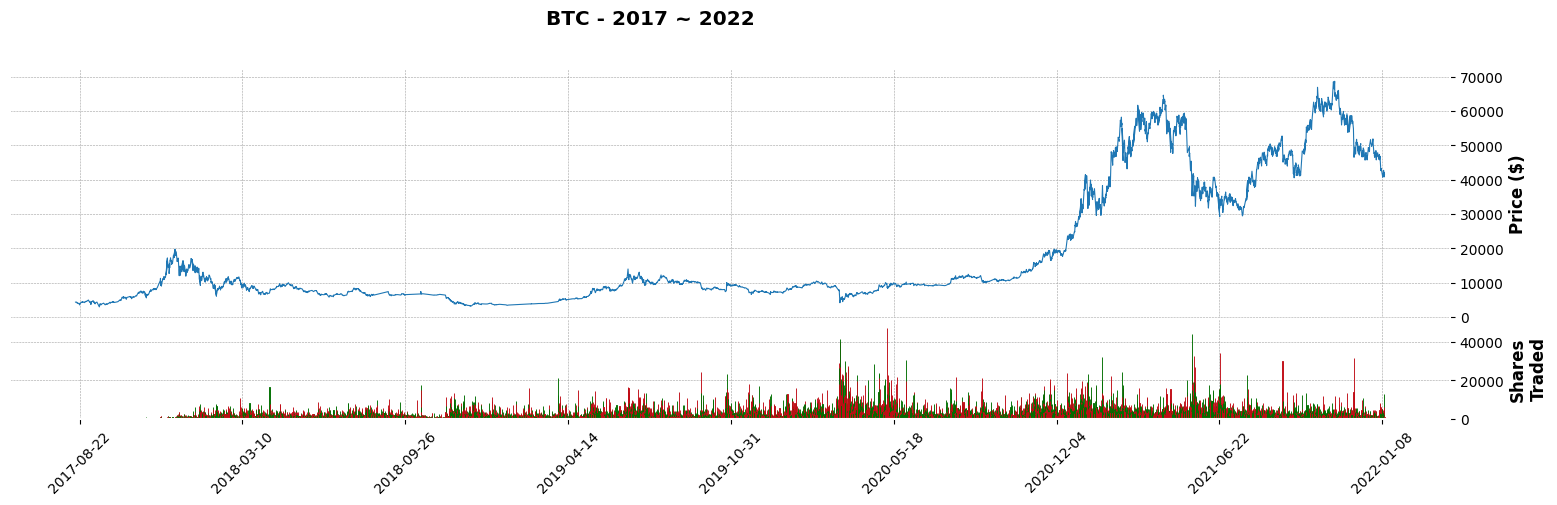

In [97]:

%matplotlib widget
%matplotlib inline

fplt.plot(
    df_plot,
    figsize=(20,5),
    type='line',
    style='charles',
    title='BTC - 2017 ~ 2022',
    ylabel='Price ($)',
    volume=True,
    ylabel_lower='Shares\nTraded',
    show_nontrading=True,
    datetime_format='%Y-%m-%d')

- Dari Grafik pergerakan harga BTC/USDT diatas, dapat ditarik informasi bahwa:
    - Lonjakan Harga beserta volatilitasnya yang signifikan dimulai dari sekitar akhiran tahun 2017 dimana harga berada pada rentang $10000 hingga $20000 dan terus berlanjut hingga harga kembali seperti semula sekitaran Maret-April 2018
    - Pada Sekitar Oktober-November 2018 harga BTC tampak mengalami downtrend cenderung turun hingga dibawah $5000-an meskipun ternyata hal itu hanyalah sesaat saja hingga pada akhirnya harga BTC mulai menanjak dengan perlahan dan kembali naik di sekitaran $10000++
    - Pada saat pandemi `Corona` mulai banyak menyebar di seluruh dunia pada sekitaran tahun Maret 2020, terlihat harga pada saat bulan mengalami penurunan dan volume jual beli yang signifikan, meskipun dimulai pada April harga kembali perlahan demi perlahan pulih
    - Pada titik ini(April 2020), justru dimulainya harga pada cryptocurrency memasuki fase `Bullish`. Dimana ini berarti pergerakan BTC akan cenderung semakin naik dari waktu ke waktu, turunan harga yang terjadi umumnya berupa koreksi harga dan akan kembali lagi naik pada akhirnya.
    - Pada titik ini juga, volume yang diperdagangkan jumlahnya semakin besar dibandingkan tahun-tahun sebelumnya terlihat dari pada bagian `Shares Traded`
    - Volatilitas dan lonjakan harga semakin menuju puncaknya dimulai pada sekitaran akhir tahun 2020 hingga harga tertinggi mencapai sekitaran $64000-an
    - Terjadi sebuah koreksi harga besar-besaran(hingga 50% dari harga puncaknya) dimulai pada pertengahan 2021, antara bulan April-Mei
    - Namun harga kembali naik dan bahkan membuat `All Time Highest`(ATH) terbaru yaitu sekitar $69000-an pada sekitaran Oktober-November 2021
    - Pada harga terakhir yang dicatat sekitaran awal tahun 2022, harga cenderung bergerak turun

### 4.4.2. Finding Some Correlation Within Spiky Prices And News

#### A. Bullish Trend In Late 2017

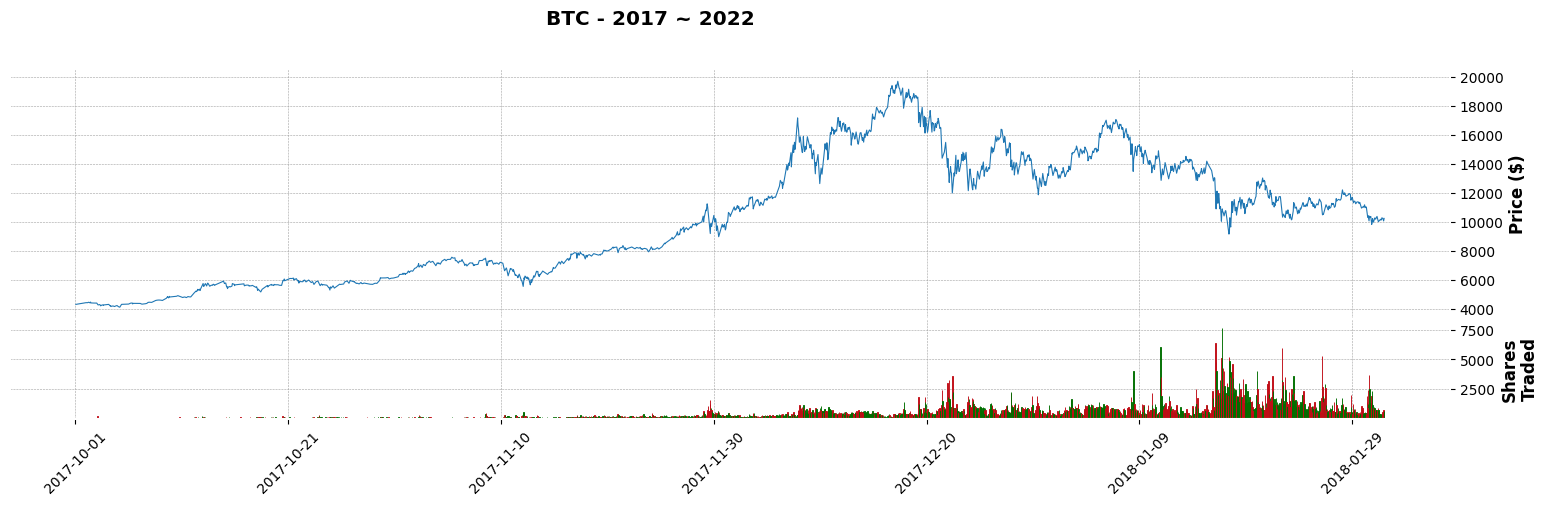

In [101]:

%matplotlib widget
%matplotlib inline

df_plot_2017 = df_plot.query('close_time >= "2017-10-01"').query('close_time <= "2018-02-01"')

fplt.plot(
    df_plot_2017,
    figsize=(20,5),
    type='line',
    style='charles',
    title='BTC - 2017 ~ 2022',
    ylabel='Price ($)',
    volume=True,
    ylabel_lower='Shares\nTraded',
    show_nontrading=True,
    datetime_format='%Y-%m-%d')

- Dari [berita ini](https://research.reading.ac.uk/research-blog/bitcoin-why-the-price-has-exploded-and-where-it-goes-from-here/#:~:text=So%20what%20has%20driven%20this,endowment%20funds%20and%20investment%20trusts.), didapatkan informasi bahwa salah satu alasannya adalah karena masuknya investor besar-besaran dari lembaga/institusi berskala besar seperti skema pensiun, university endowment funds , dan investor terpercaya. Cryptocurrency pada tahap ini juga sudah mulai dilirik oleh tokoh-tokoh besar khususnya pada bidang Ekonomi. Pada tahun ini bisa dibilang kenaikan harga yang terjadi disebabkan dengan kombinasi BTC yang mulai dilirik banyak orang dan rasa untuk tidak ingin tertinggal dengan hal tersebut(FOMO), sehingga saat koreksi terjadi, harga bitcoin kembali ke seperti sedia kala.
- Namun kabar baiknya adalah, pada tahap ini pula perkembangan project Cryptocurrency khususnya teknologi yang menjalankan ini semua yaitu `Blockchain`. Mendapat perhatian lebih pada kalangan pengembang dibidang teknologi, sehingga perkembangan teknologi Blockchain pada tahap ini kian pesat dan terus berjalan

#### B. First Covid Pandemic On 2020 Affecting The Whole Section of Economy Including Cryptocurrency

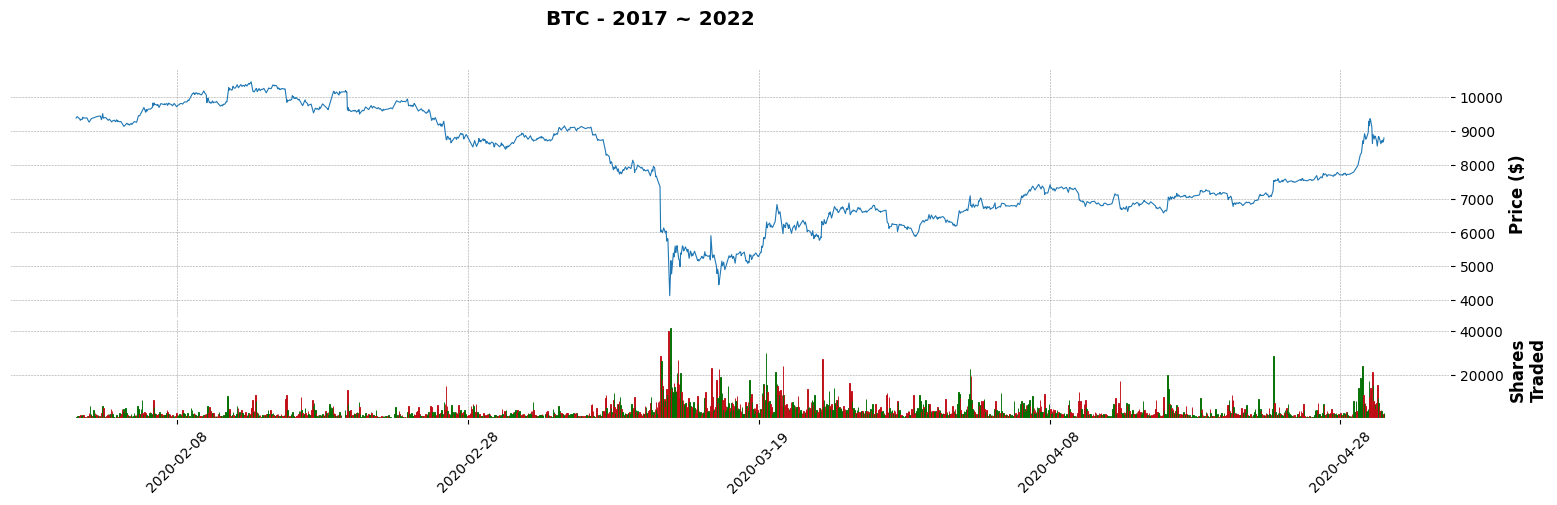

In [102]:

%matplotlib widget
%matplotlib inline

df_plot_2020 = df_plot.query('close_time >= "2020-02-01"').query('close_time <= "2020-05-01"')

fplt.plot(
    df_plot_2020,
    figsize=(20,5),
    type='line',
    style='charles',
    title='BTC - 2017 ~ 2022',
    ylabel='Price ($)',
    volume=True,
    ylabel_lower='Shares\nTraded',
    show_nontrading=True,
    datetime_format='%Y-%m-%d')

- Saat kasus Corona pertama kali diumumkan sebagai wabah pandemik di seluruh dunia pada Maret 2020, (pengumuman terkait dari WHO dapat dilihat [disini](https://www.who.int/director-general/speeches/detail/who-director-general-s-opening-remarks-at-the-media-briefing-on-covid-19---11-march-2020#:~:text=WHO%20has%20been%20assessing%20this,to%20use%20lightly%20or%20carelessly.)) banyak bidang yang berkaitan dengan ekonomi mengalami dampak kerugian yang signifikan. Hal ini juga dialami pada Cryptocurrency khususnya BTC.
- Terlihat jelas pada bulan ini (Maret), volume yang diperdagangkan jumlahnya sangat besar dibandingkan bulan-bulan sebelumnya dan bahkan pada bulan setelahnya
- Namun seperti yang telah dikatakan sebelumnya, pada titik ini justru Cryptocurrency masuk ke dalam fase `Bullish` dimana harga cenderung akan naik dari waktu ke waktu

#### C. The New Era Of Cryptocurrency Bringing BTC Price Surge Up To $60000 on 2021

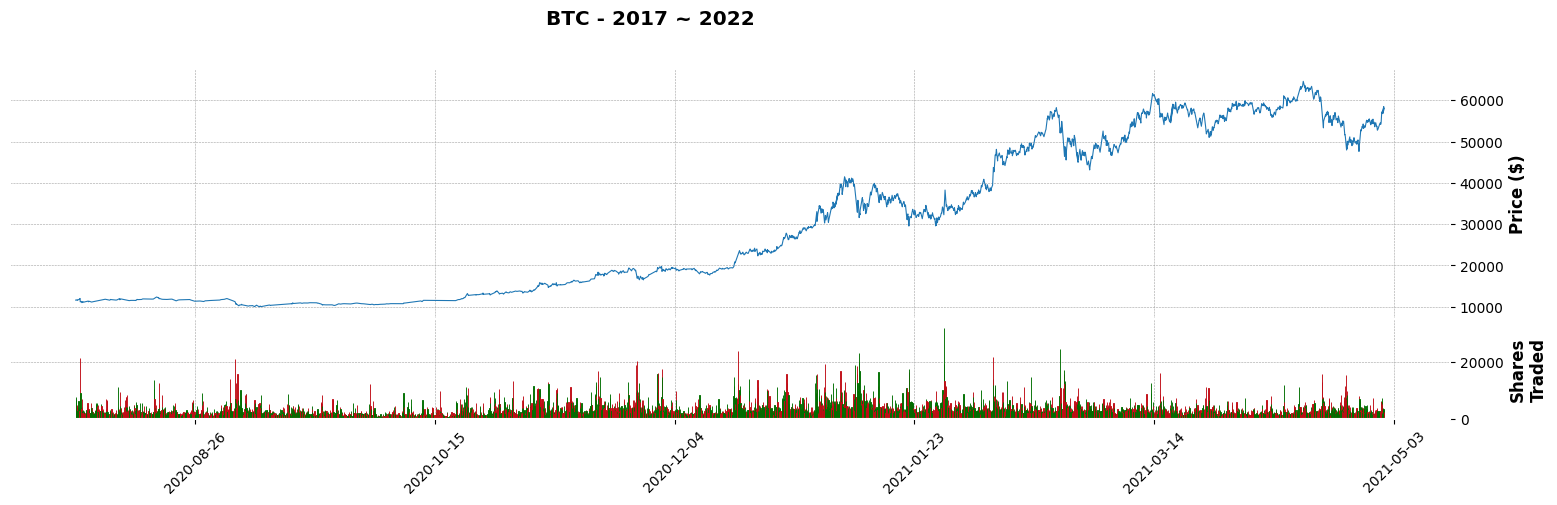

In [104]:

%matplotlib widget
%matplotlib inline

df_plot_2021 = df_plot.query('close_time >= "2020-08-01"').query('close_time <= "2021-05-01"')

fplt.plot(
    df_plot_2021,
    figsize=(20,5),
    type='line',
    style='charles',
    title='BTC - 2017 ~ 2022',
    ylabel='Price ($)',
    volume=True,
    ylabel_lower='Shares\nTraded',
    show_nontrading=True,
    datetime_format='%Y-%m-%d')

- Banyak hal yang terjadi pada fase ini. Project-project cryptocurrency yang sebelumnya dikembangkan, sudah banyak pada tahap `live` dan siap untuk digunakan oleh khalayak umum. Cara trading baru seperti Liquid Swap mulai populer dan banyak dilakukan, Pengenalan dan pengimplementasian Decentralized Finance atau biasa disingkat dengan `DeFi` juga terlaksana dalam kurun waktu interval ini. Dan salah satu berita yang terkenal ialah perusahaan milik `Elon Musk` yaitu tesla menerbitkan laporan keuangan dimana mereka menginvestasikan sebagian dana mereka kedalam bitcoin (berita dapat dilihat [disini](https://www.cnbc.com/2021/02/08/tesla-buys-1point5-billion-in-bitcoin.html))

### 4.4.3. Finding The Best Time Step/Sequence Length

- Karena kita seorang day trader dan sering melihat pergerakan harga berdasarkan time frame per 1 jam, maka hendaknya kita mencari informasi terlebih dahulu salah satu teknikal analisis yang umum digunakan dan berapa panjang interval yang ideal untuk teknikal analisis tersebut.
- Salah satu yang kita gunakan ialah `Moving Average(MA)`, dan didapat informasi (dari [artikel ini](https://www.investopedia.com/articles/active-trading/010116/perfect-moving-averages-day-trading.asp#:~:text=Moving%20averages%20add%20reliability%20to,the%20long%20and%20short%20sides.))bahwa timeframe yang umum digunakan ialah 5, 8, dan 13.
- Selain interval yang cenderung pendek tersebut, Moving Average sebesar 50 juga cocok khususnya pada trading berjangka menengah ([artikel terkait](https://tradeciety.com/how-to-use-moving-averages/)). Maka kita akan coba membandingkan Moving Average ini khususnya 50 dengan interval yang lebih pendek
- Dari sini, kita menetapkan bahwa `Time Step` yang digunakan mayoritas model **adalah** `5` dan membandingkan salah satunya dengan time step yang lebih panjangan yaitu `505

## **5. Data Preprocessing**

### 5.1. Split Dataset

In [37]:
# Split data into train and test

train_data_length = len(df) - 168

data_train = df.iloc[:train_data_length]
X_test = df.iloc[train_data_length:]

In [38]:
# Split train set into train and validation

train_data_length = math.ceil(data_train.shape[0] * 0.9)

X_train = data_train.iloc[:train_data_length]
X_val = data_train.iloc[train_data_length:]

### 5.2. Feature Selection

- Karena kita hanya memprediksi harga penutupan tiap data `time series`-nya, maka kita hanya akan memilih kolom close

In [39]:
X_train_selected = X_train['close']
X_val_selected = X_val['close']
X_test_selected = X_test['close']

### 5.3. Checking Outliers

- Meskipun kita tidak akan menghapus outlier yang ditemukan, karena kita membutuhkan informasi rentang yang dihasilkan dari tiap-tiap pergerakan harga. It's a good habit untuk sekedar check batas maksimum data sebelum dianggap outlier dan berapa persentasenya

In [40]:
preprocess_handling = pd.DataFrame({'columns' : [], 'skew' :[]})
preprocess_handling.loc[0] = ['close', X_train_selected.skew(axis=0)]
preprocess_handling.reset_index(drop=True, inplace=True)

preprocess_handling['status'] = np.where(preprocess_handling['skew'].abs()>0.5, 'Skewed', 'Normal')

In [41]:
    
# Since it's skewed, we are using IQR to handle outliers

def find_skewed_boundaries(df, distance):
  IQR = df.quantile(0.75) - df.quantile(0.25)

  lower = df.quantile(0.25) - distance * IQR
  upper = df.quantile(0.75) + distance * IQR

  return upper, lower

In [42]:

outliers={}
upper_boundary, lower_boundary = find_skewed_boundaries(X_train_selected, 3)
print(f"Batas lower dan upper untuk close:{lower_boundary, upper_boundary}")
outliers[f"outliers{j}"] = np.where(X_train_selected > upper_boundary, True, np.where(X_train_selected < lower_boundary, True, False))


Batas lower dan upper untuk close:(-8519.71, 26689.625)


In [43]:
for i, (k, v) in enumerate(outliers.items()):
    X_train_trimmed_sim = X_train.loc[~outliers[k]]
    preprocess_handling.loc[i,'trimmed_row'] = X_train.shape[0] - X_train_trimmed_sim.shape[0]
    preprocess_handling.loc[i,'percentage'] = np.round(100-(X_train_trimmed_sim.shape[0]/X_train.shape[0]*100), 2)

preprocess_handling

,columns,skew,status,trimmed_row,percentage
0,close,2.129989,Skewed,5045.0,14.66


- Terlihat persentase outlier pada kolom close, kurang lebih berkisat 14.66%

### 5.4. Feature Scaling

- Seperti yang telah dijelaskan sebelumnya pada tahap EDA, kita akan menggunakan teknik MinMaxScaler

In [44]:
scaler = MinMaxScaler()
scaler.fit(X_train_selected.values.reshape(-1, 1))

X_train_scaled = scaler.transform(X_train_selected.values.reshape(-1, 1))
X_val_scaled = scaler.transform(X_val_selected.values.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test_selected.values.reshape(-1, 1))

### 5.5. Feature Extraction

- Karena data yang akan kita olah bersifat sequence, dimana antara satu informasi memiliki keterkaitan dengan informasi selanjutnya. Maka kita akan mengubah bentuk data, yang pada awalnya tersimpan tiap baris secara independent. Akan dihubungkan satu sama lain hingga mencapai 5 kolom dan kolom selanjutnya(ke 6 pada kasus ini) dijadikan sebagai label atau target yang akan diprediksi

In [45]:
sequence_length = 5

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y

In [46]:
X_train_final, y_train = partition_dataset(sequence_length, X_train_scaled)
X_val_final, y_val = partition_dataset(sequence_length, X_val_scaled)
X_test_final, y_test = partition_dataset(sequence_length, X_test_scaled)


In [47]:
print(f"Nilai X train pada index ke 5 sebelum ekstraksi :{X_train_scaled[5]}")
print(f"Nilai X Train index ke 1 setelah ekstraksi:{X_train_final[1][sequence_length-1][0]}")
print(f"Nilai y Train pada index ke 0 :{y_train[0]}")

Nilai X train pada index ke 5 sebelum ekstraksi :[0.0247331]
Nilai X Train index ke 1 setelah ekstraksi:0.024733101453073766
Nilai y Train pada index ke 0 :0.024733101453073766


### 5.6 Preprocessing Input Layer

- Untuk menggunakan pipeline pada dataset, akan dibentuk menjadi data tensor, oleh karena itu kita menggunakan preprocessing input layer pada tensorflow, dimana data-data kita akan dipecah dan dikelompokkan satu sama lain sebelum masuk tahap training model Neural Network

In [48]:
import tensorflow as tf

#Train Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_final, y_train)).batch(128)

#Validation Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_final, y_val)).batch(128)

#Test Dataset
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test)).batch(64)

## **6. Model Definition**

In [49]:
base_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# Model

base_model.add(layers.SimpleRNN(5, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
base_model.add(layers.SimpleRNN(2, return_sequences=True))
base_model.add(layers.SimpleRNN(1))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 30; batch_size = 128; patience = 6;

base_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

# early_stop = EarlyStopping(monitor='loss', 
#                            patience=patience, 
#                            verbose=0)

base_model.summary()

timesteps: 5, features: 1, neurons: 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 5)              35        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 5, 2)              16        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1)                 4         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


## **7. Model Training**

In [50]:
parameter_list = ['epochs: ' + str(epochs), 'batch_size: ' + str(batch_size), 'patience: ' + str(patience), 'optimizer: ' + str(optimizer), 'loss: ' + str(loss)]
print('Parameters: ' + str(parameter_list))

Parameters: ['epochs: 30', 'batch_size: 128', 'patience: 6', 'optimizer: adam', 'loss: mean_squared_error']


In [51]:
base_model_hist = base_model.fit(
                    train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    verbose=0
                )

## **8. Model Evaluation**

### 8.1. Create Baseline Evaluation

- Sebagai benchmark awal, kita akan menggunakan metode bernama `naive forecasting` untuk melihat performa prediksi jika dilihat hanya semata-mata dari selisih data harga yang akan diprediksi dengan data terakhir pada tiap baris. Ini berguna agar nantinya kita dapat mengtahui apakah model kita ini memiliki performa lebih baik dibandingkan dengan metode yang ala kadarnya ini.

- Evaluasi yang akan kita gunakan ialah `MSE dan RMSE` pada validation set. Karena informasi rentang yang kita gunakan memiliki pengaruh pada evaluasi ini. Dan diharapkan jika mendapatkan loss yang kecil dari evaluasi ini, akan memiliki pengaruh juga dengan pengujian test set
 
- Sedangkan pada tahap pengujian Test set kita akan menggunakan `MAE`, kita menggunakan `MAE` karena selisih yang dihasilkan entah selisih positif ataupun negatif tidak akan memberikan dampak yang berlipat ganda, dalam artian jika selisih negatif -1000 maka kerugian yang kita terima juga 1000. Tidak menjadi 1100 ataupun lebih dari itu

In [140]:
evaluation_metrics = pd.DataFrame({'Model':[], 'Details' : [], 'MSE': [], 'RMSE': [], 'MAE(Test)': []})
# evaluation_metrics.style.format({'RMSE(Test)': '{:.2f} $'})

In [53]:
# rmse = tf.keras.metrics.RootMeanSquaredError()
# rmse.update_state(y_test, y_pred_test)
# test_result = rmse.result().numpy()
# test_result = scaler.inverse_transform(test_result.reshape(-1, 1))
# test_result

In [141]:
y_pred_base = X_val_final[: -1]
y_pred_test = X_test_final[: -1]
# y_pred_test = scaler.inverse_transform(y_pred_test.reshape)

# calculate mse and rmse
mse_last_value = np.mean(tf.keras.losses.mean_squared_error(y_val, y_pred_base))
rmse_last_value = np.sqrt(mse_last_value)
mae_last_value_test = np.mean(tf.keras.metrics.mean_absolute_error(y_test, y_pred_test))
evaluation_metrics.loc[0] = ['Naive Forecasting', 'Difference of Last Value in X val with y val', mse_last_value, rmse_last_value, mae_last_value_test]

In [142]:
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797


### 8.2. Base Recurrent Neural Network Evaluation

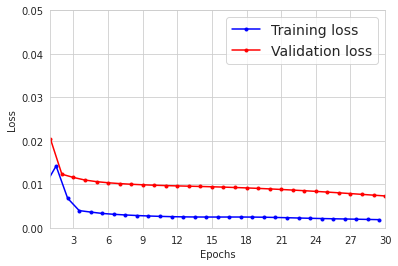

In [56]:
# Visualization of Training Loss and Validation Loss

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, epochs, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(base_model_hist.history["loss"], base_model_hist.history["val_loss"])
plt.show()

In [57]:
mse_base_deep_rnn = base_model.evaluate(X_val_final, y_val)
rmse_base_deep_rnn = np.sqrt(mse_base_deep_rnn)

120/120 [==============================] - 1s 6ms/step - loss: 0.0073 - mean_squared_error: 0.0073


In [143]:
y_pred_test_base = base_model.predict(X_test_final)
mae_base_deep_rnn_test = mean_absolute_error(y_test, y_pred_test_base)
evaluation_metrics.loc[1] = ['Base Deep RNN', 'Neuron=5, Timestep=5, Epoch=35, Multi Layers', mse_base_deep_rnn[0], rmse_base_deep_rnn[0], mae_base_deep_rnn_test]
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.007323,0.085576,0.016042


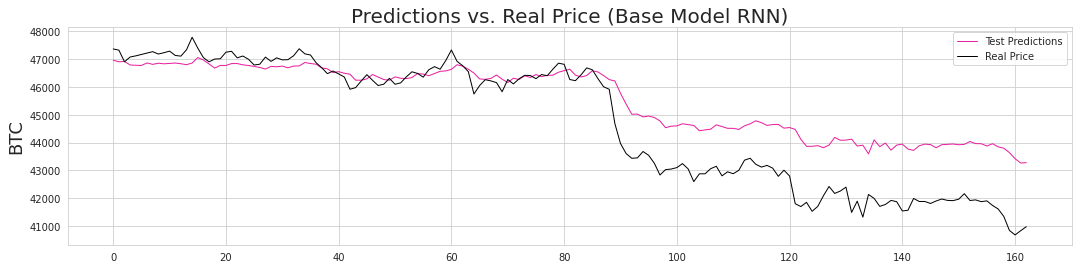

In [59]:
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_base = scaler.inverse_transform(y_pred_test_base)
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (Base Model RNN)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_test_base, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")

# valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
# valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
# plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

## **9. Model Improvement**

### 9.1. Improved Recurrent Neural Network

In [60]:
deep_base = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# Model

deep_base.add(layers.SimpleRNN(5, return_sequences=True, input_shape=(None, X_train_final.shape[2])))
deep_base.add(layers.SimpleRNN(5, return_sequences=True))
deep_base.add(layers.SimpleRNN(2))
deep_base.add(layers.Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 40; batch_size = 128; patience = 6;

deep_base.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

deep_base.summary()

timesteps: 5, features: 1, neurons: 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 5)           35        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 5)           55        
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 2)                 16        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [61]:
deep_model_hist = deep_base.fit(
                    train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    verbose=0
                )

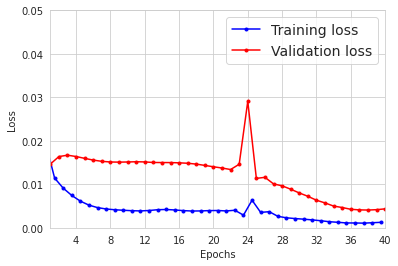

In [62]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(deep_model_hist.history["loss"], deep_model_hist.history["val_loss"])
plt.show()

In [63]:
mse_imp_deep_rnn = deep_base.evaluate(X_val_final, y_val)
rmse_imp_deep_rnn = np.sqrt(mse_imp_deep_rnn)

120/120 [==============================] - 1s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044


In [144]:
y_pred_imp_deep = deep_base.predict(X_test_final)
mae_imp_deep_rnn_test = mean_absolute_error(y_test, y_pred_imp_deep)
evaluation_metrics.loc[2] = ['Improved Deep RNN - Dense Output', 'Neuron=5, Timestep=5, Epoch=50, Batch_size=128, Multi Layers', mse_imp_deep_rnn[0], rmse_imp_deep_rnn[0], mae_imp_deep_rnn_test]
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.007323,0.085576,0.016042
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.004355,0.065994,0.027428


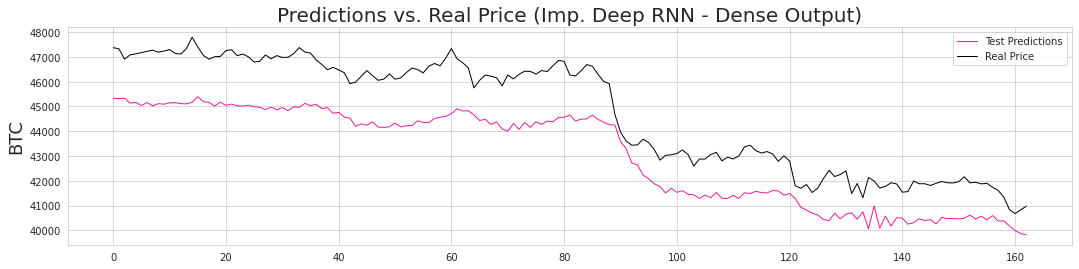

In [65]:
y_pred_imp_deep = scaler.inverse_transform(y_pred_imp_deep)

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (Imp. Deep RNN - Dense Output)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_imp_deep, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

### 9.2. LSTM Recurrent Neural Network

#### 9.2.1. With Tensor Pipeline

In [109]:
lstm_imp_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_imp_model
lstm_imp_model.add(LSTM(5, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
lstm_imp_model.add(LSTM(2))
lstm_imp_model.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_imp_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_imp_model.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 5)           140       
                                                                 
 lstm_7 (LSTM)               (None, 2)                 64        
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [110]:
lstm_imp_model_hist = lstm_imp_model.fit(
                    train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    verbose=0
                )

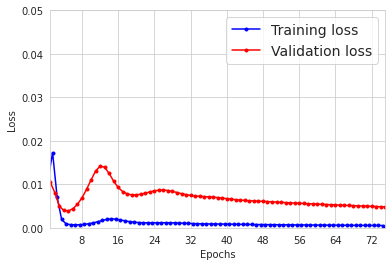

In [111]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_imp_model_hist.history["loss"], lstm_imp_model_hist.history["val_loss"])
plt.show()

In [112]:
mse_lstm_imp_rnn = lstm_imp_model.evaluate(X_val_final, y_val)
rmse_lstm_imp_rnn = np.sqrt(mse_lstm_imp_rnn)

120/120 [==============================] - 3s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048


In [145]:
y_pred_lstm_pipe = lstm_imp_model.predict(X_test_final)
mae_lstm_imp_rnn_test = mean_absolute_error(y_test, y_pred_lstm_pipe)
evaluation_metrics.loc[3] = ['LSTM - Pipeline Dataset', 'Neuron=5, Timestep=5, Epoch=75, Batch_size=128, Multi Layers', mse_lstm_imp_rnn[0], rmse_lstm_imp_rnn[0], mae_lstm_imp_rnn_test]
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.007323,0.085576,0.016042
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.004355,0.065994,0.027428
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.004813,0.069372,0.034001


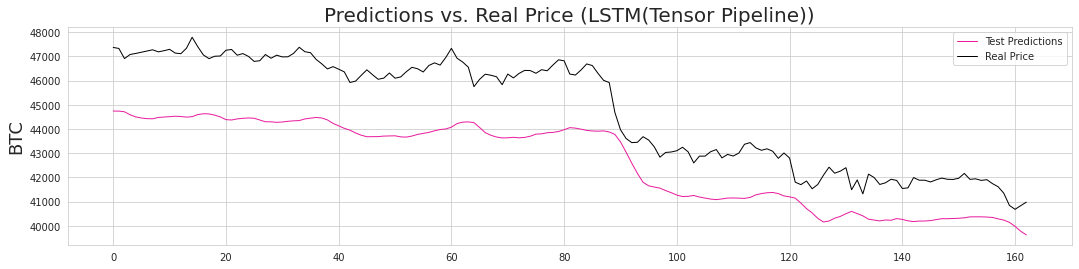

In [114]:
y_pred_lstm_pipe = scaler.inverse_transform(y_pred_lstm_pipe)
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(Tensor Pipeline))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_pipe, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

#### 9.2.2. Without Tensor Pipeline

- Karena tampaknya LSTM dan model model sebelumnya tidak memiliki hasil prediksi yang baik, maka kita akan mencoba melatih model dengan data yang tanpa sebelum dijadikan data tensor (tanpa pipeline)

In [72]:
lstm_imp_model_2 = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_imp_model_2
lstm_imp_model_2.add(LSTM(5, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
lstm_imp_model_2.add(LSTM(2))
lstm_imp_model_2.add(Dense(1, activation='linear'))

# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_imp_model_2.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_imp_model_2.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 5)           140       
                                                                 
 lstm_3 (LSTM)               (None, 2)                 64        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [73]:
lstm_imp_model_hist_2 = lstm_imp_model_2.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final, y_val),
                    verbose=0
                )

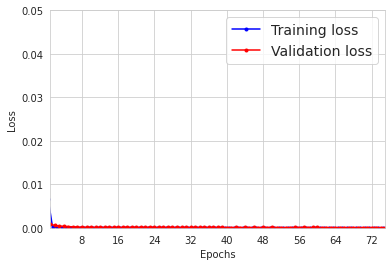

In [74]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_imp_model_hist_2.history["loss"], lstm_imp_model_hist_2.history["val_loss"])
plt.show()

In [75]:
mse_lstm_imp_rnn_2 = lstm_imp_model_2.evaluate(X_val_final, y_val)
rmse_lstm_imp_rnn_2 = np.sqrt(mse_lstm_imp_rnn_2)

120/120 [==============================] - 1s 4ms/step - loss: 4.8411e-05 - mean_squared_error: 4.8411e-05


In [146]:
y_pred_lstm_non = lstm_imp_model_2.predict(X_test_final)
mae_lstm_imp_rnn_2_test = mean_absolute_error(y_test, y_pred_lstm_non)
evaluation_metrics.loc[4] = ['LSTM - Non-Pipeline Dataset', 'Without tensorflow pipeline dataset. The rest is same', mse_lstm_imp_rnn_2[0], rmse_lstm_imp_rnn_2[0], mae_lstm_imp_rnn_2_test]
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.007323,0.085576,0.016042
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.004355,0.065994,0.027428
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.004813,0.069372,0.034001
4,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000048,0.006958,0.003717


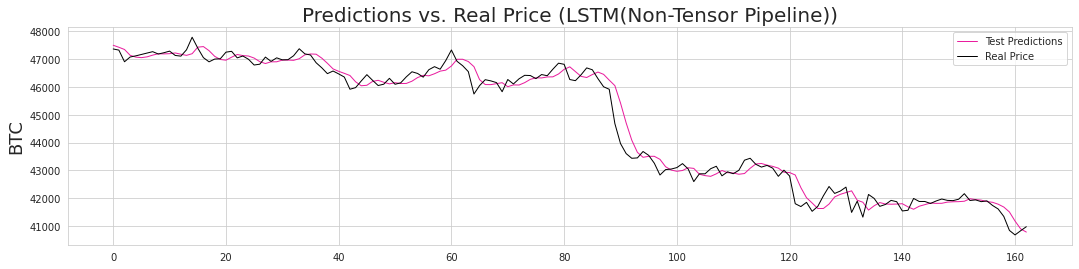

In [77]:
y_pred_lstm_non = scaler.inverse_transform(y_pred_lstm_non)
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(Non-Tensor Pipeline))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_non, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

- Disini terlihat model memprediksi harga jauh lebih baik dibandingkan dengan model-model sebelumnya, harga yang diprediksi pun juga reaktif atau memiliki kenaikan atau turunan yang mengikuti pola harga aslinya, meskipun terlihat cenderung terdapat lagging pada harga yang diprediksi

### 9.3. GRU Recurrent Neural Network

In [78]:
gru_imp_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The gru_imp_model
gru_imp_model.add(GRU(5, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
gru_imp_model.add(GRU(2))
gru_imp_model.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

gru_imp_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=patience, 
                           verbose=0)

gru_imp_model.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 5)           120       
                                                                 
 gru_1 (GRU)                 (None, 2)                 54        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [79]:
gru_imp_model_hist = gru_imp_model.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final, y_val),
                    verbose=0
                )

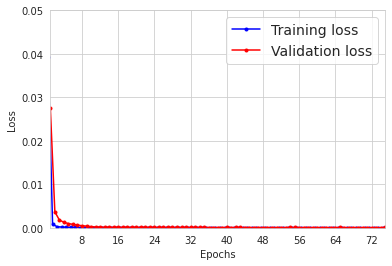

In [80]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(gru_imp_model_hist.history["loss"], gru_imp_model_hist.history["val_loss"])
plt.show()

In [81]:
mse_gru_imp_rnn = gru_imp_model.evaluate(X_val_final, y_val)
rmse_gru_imp_rnn = np.sqrt(mse_gru_imp_rnn)

120/120 [==============================] - 0s 4ms/step - loss: 8.0009e-05 - mean_squared_error: 8.0009e-05


In [147]:
y_pred_gru_non = gru_imp_model.predict(X_test_final)
mae_gru_imp_test = mean_absolute_error(y_test, y_pred_gru_non)
evaluation_metrics.loc[5] = ['GRU - Non-Pipeline Dataset', 'Without tensorflow pipeline dataset. The rest is same', mse_gru_imp_rnn[0], rmse_gru_imp_rnn[0], mae_gru_imp_test]
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.007323,0.085576,0.016042
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.004355,0.065994,0.027428
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.004813,0.069372,0.034001
4,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000048,0.006958,0.003717
5,GRU - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000080,0.008945,0.005035


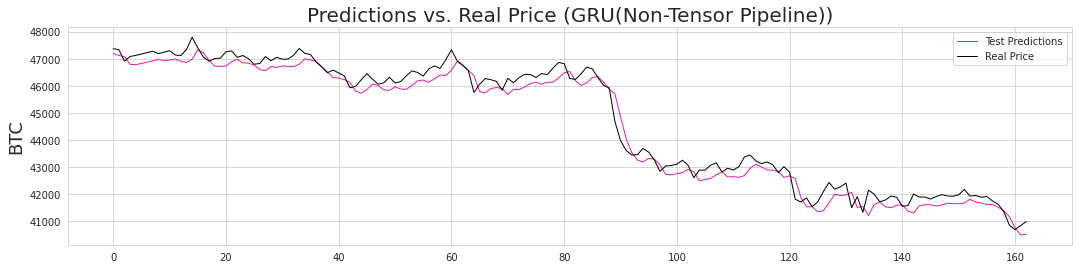

In [83]:
y_pred_gru_non = scaler.inverse_transform(y_pred_gru_non)

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (GRU(Non-Tensor Pipeline))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_gru_non, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

### 9.4 LSTM With 50 Time Step/Sequence Length

- Kita akan mencoba mengubah panjang time step menjadi 50, untuk mengetahui apakah model dapat memprediksi lebih baik jika memiliki informasi yang disimpan dalam dataset jauh lebih besar

In [115]:
sequence_length_2 = 50

def partition_dataset(sequence_length_2, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length_2, data_len):
        x.append(data[i-sequence_length_2:i,:]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y
    
X_train_final_2, y_train_2 = partition_dataset(sequence_length_2, X_train_scaled)
X_val_final_2, y_val_2 = partition_dataset(sequence_length_2, X_val_scaled)
X_test_final_2, y_test_2 = partition_dataset(sequence_length_2, X_test_scaled)


In [116]:
lstm_24_seq = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_24_seq
lstm_24_seq.add(LSTM(50, return_sequences=True, input_shape=(None, X_train_final.shape[2])))
lstm_24_seq.add(LSTM(5))
lstm_24_seq.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 50; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_24_seq.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_24_seq.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 50', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 50)          10400     
                                                                 
 lstm_9 (LSTM)               (None, 5)                 1120      
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 11,526
Trainable params: 11,526
Non-trainable params: 0
_________________________________________________________________


In [117]:
lstm_24_seq_hist = lstm_24_seq.fit(
                    X_train_final_2,
                    y_train_2,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final_2, y_val_2),
                    verbose=0
                )

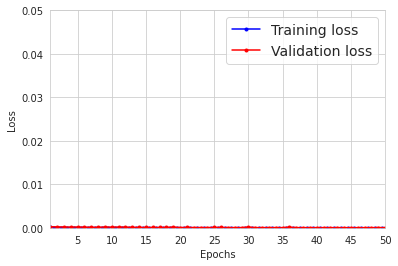

In [118]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_24_seq_hist.history["loss"], lstm_24_seq_hist.history["val_loss"])
plt.show()

In [119]:
mse_lstm_24_seq = lstm_24_seq.evaluate(X_val_final_2, y_val_2)
rmse_lstm_24_seq = np.sqrt(mse_lstm_24_seq)

118/118 [==============================] - 1s 9ms/step - loss: 3.8168e-05 - mean_squared_error: 3.8168e-05


In [148]:
y_pred_lstm_24 = lstm_24_seq.predict(X_test_final_2)
mae_lstm_24_seq = mean_absolute_error(y_test_2, y_pred_lstm_24)
evaluation_metrics.loc[6] = ['LSTM - 50 Sequence Length', 'Timestep=50, without tensorflow pipeline dataset. The rest is same', mse_lstm_24_seq[0], rmse_lstm_24_seq[0], mae_lstm_24_seq]
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.028753,0.169566,0.039797
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.007323,0.085576,0.016042
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.004355,0.065994,0.027428
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.004813,0.069372,0.034001
4,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000048,0.006958,0.003717
5,GRU - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000080,0.008945,0.005035
6,LSTM - 50 Sequence Length,"Timestep=50, without tensorflow pipeline datas...",0.000038,0.006178,0.003703


- MSE pada validation set maupun MAE pada Training set mendapatkan nilai loss yang lebih kecil jika dibandingkan dengan model yang sama namun memiliki sequence atau time step yang lebih pendek

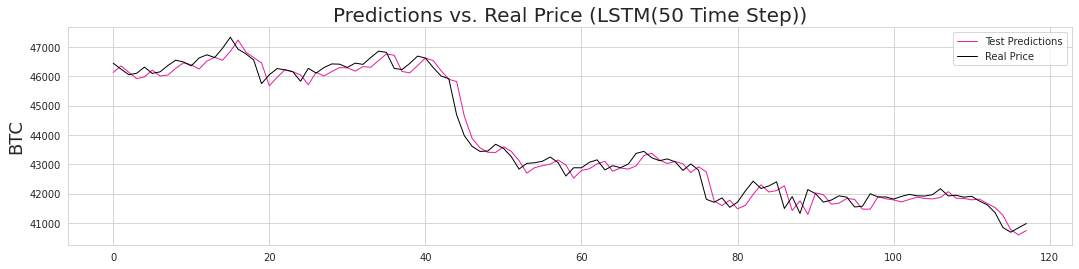

In [121]:
y_pred_lstm_24 = scaler.inverse_transform(y_pred_lstm_24)
y_test_2_real = scaler.inverse_transform(y_test_2.reshape(-1, 1))

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(50 Time Step))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_24, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_2_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

- Model juga terlihat memprediksi harga lebih mendekati dengan harga aslinya jika kita bandingkan dengan model-model sebelumnya

## **10. Model Saving**

### 10.1. Choose The Best Model

In [122]:
y_dummy_price = []
for i in range(0, 45):
    y_dummy_price.append(43000)
    
y_pred_lstm_24_compare = y_pred_lstm_24
y_pred_lstm_24_compare = np.insert(y_pred_lstm_24_compare, 0, np.array(y_dummy_price).reshape(-1,1), axis=0)

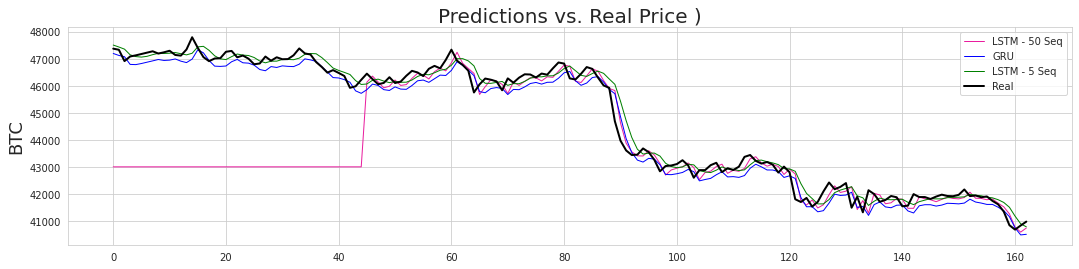

In [123]:
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price )", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_24_compare, color="#E91D9E", linewidth=1.0)
plt.plot(y_pred_gru_non, color="blue", linewidth=1.0)
plt.plot(y_pred_lstm_non, color="green", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=2.0)
plt.legend(["LSTM - 50 Seq", "GRU", "LSTM - 5 Seq", "Real"], loc="upper right")
plt.show()

- Pada hasil evaluasi MAE dan MSE sebelumnya, model LSTM dengan 50 Sequence length mendapatkan hasil untuk MAE(Validation set)=0.000038 dan untuk MAE(Test set)=0.003703 yang menandakan model ini berperforma lebih baik secara keseluruhan jika dibandingkan dengan model-model sebelumnya.
- Dari perbandingkan plot diatas, terlihat LSTM- 50 Sequence length(garis berwarna pink) memiliki posisi prediksi harga yang lebih dekat dengan harga aslinya jika dibandingkan model yang sama-sama memiiki performa baik

- Dengan pertimbangan ini kita menetapkan bahwa model `LSTM-50 Sequence Length` akan kita gunakan sebagai model yang memprediksi data baru(inference) baik pada notebook ini ataupun


### 10.2. Scaling Pipeline

In [124]:
with open("scale_pipe.pkl", "wb") as f:
    pickle.dump(scaler, f)

### 10.3. Save Deep Learning Model

In [125]:
# save model
lstm_24_seq.save('lstm_24.h5')
print('Model Saved!')

Model Saved!


## **11. Model Inference**

In [126]:
df_inf = pd.read_csv('inference/BTCUSDT-1h-2022-02.csv', header=None)

In [127]:
# df_inf[0] = pd.to_datetime(df_inf[0],unit='ms')
# df_inf[6] = pd.to_datetime(df_inf[6],unit='ms')

row_inf = 7 * 24
df_inf_selected = df_inf[:row_inf].iloc[:, 4]

In [128]:
from tensorflow.keras.models import load_model
# load scaling preprocessing
with open("scale_pipe.pkl", "rb") as f:
    pipeline = pickle.load(f)

# load deep learning model
lstm_24_seq_load = load_model('lstm_24.h5')


In [129]:
df_inf_scaled = pipeline.transform(df_inf_selected.values.reshape(-1, 1))

In [130]:
sequence_length = 50

def partition_dataset_inf(sequence_length, data):
    x = []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
    
    x = np.array(x)
    return x

In [131]:
df_inf_scaled = partition_dataset_inf(sequence_length, df_inf_scaled)

In [132]:
y_pred_inf = lstm_24_seq_load.predict(df_inf_scaled)

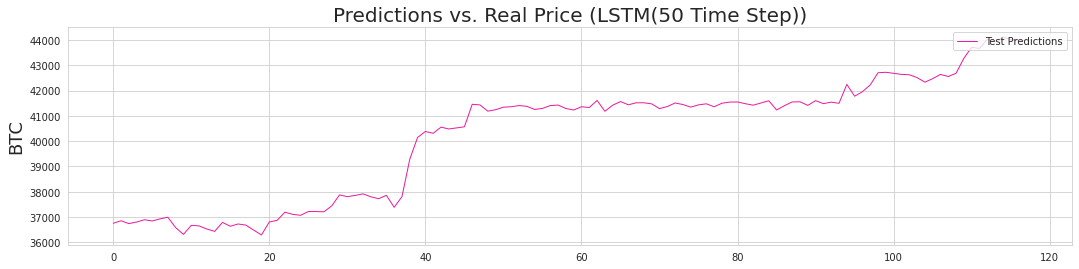

In [133]:
y_pred_inf_real = pipeline.inverse_transform(y_pred_inf)

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(50 Time Step))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_inf_real, color="#E91D9E", linewidth=1.0)

plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

- Kita akan mencoba memprediksi harga dengan menambahkan satu data baru, yang dimana dari informasi data sebelumnya ditambah dengan data ini, berapakah harga yang akan diprediksi oleh model

In [134]:
df_inf_selected[len(df_inf_selected)+1] = 44500

In [135]:
df_inf_scaled = pipeline.transform(df_inf_selected.values[len(df_inf_selected)-50:].reshape(-1, 1))

In [136]:
df_inf_scaled = df_inf_scaled.reshape(-1, 50, 1)

In [137]:
y_pred_inf = lstm_24_seq_load.predict(df_inf_scaled)
y_pred_inf_s = pipeline.inverse_transform(y_pred_inf)
print(f"Prediksi Harga Penutupan Bitcoin Satu Jam Kedepan: ${scaler.inverse_transform(y_pred_inf)[0][0]}")

Prediksi Harga Penutupan Bitcoin Satu Jam Kedepan: $44385.55078125


In [138]:
df_real = scaler.inverse_transform(df_inf_scaled.reshape(1,-1))

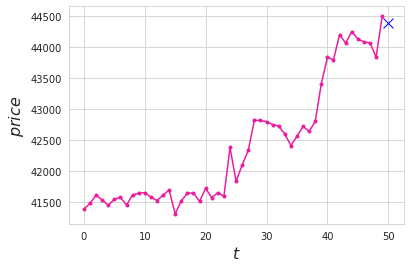

In [139]:
# Visualization of the First Three Data

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$price$"):
    plt.plot(series, ".-", color="#E91D9E")
    if y is not None:
        plt.plot(50, y, "bx", markersize=10, color="blue")
    if y_pred is not None:
        plt.plot(50, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16,)
    if y_label:
        plt.ylabel(y_label, fontsize=16)

plot_series(df_real.reshape(-1), y_pred_inf_s[0][0])

- Ternyata harga yang diprediksi ialah $44385.55 yang berarti harga bergerak turun dari harga sebelumnya. Karena hal ini, kita tidak akan melakukan posisi `Open Trade`

<hr>

## **11. Conclusion**

Dari sisi model:
- Kita telah berhasil membuat berbagai macam model dimana kita memilih model `LSTM - 50 Sequence Length` sebagai model terbaik dan akan digunakan sebagai model yang akan memprediksi harga terkini

Dari sisi dataset:
- Pergerakan harga BTC cenderung bergerak dengan alasan-alasan fundamental yang mendasarinya seperti entah berita baik ataupun berita buruk yang terjadi
- BTC terlihat memiliki volatilitas yang tinggi dimana nilai terlihat dari varians/std-nya cukup tinggi

Pengembangan lebih lanjut:
- Dengan mengetahui bahwa pergerakan BTC juga dipengaruhi oleh sentimen-sentimen yang terjadi khususnya pada komunitas cryptocurrency, nampaknya akan dijadikan sebuah pertimbangan dengan memasukan analisis sebagai salah satu penentu prediksi pergerakan harga BTC
- Time Frame yang lebih bervariasi(1 hari, 1 bulan ataupun bahkan 5 menit) juga dapat dimasukkan untuk mengembangkan model lainnya yang disesuaikan dengan jenis atau cara trading yang dilakukan oleh tiap-tiap individu